#Implementing EfficientNetV2L

##Installing the Dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sricharansridhar","key":"18c167e8b82f63fc58149437a0a61305"}'}

In [4]:
!pip install kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [5]:
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
    zip_ref.extractall()

##Data Augmentation

In [6]:
!pip install tensorflow keras-efficientnet-v2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
dataset_path = "chest_xray"

train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

IMG_SIZE = (480, 480)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Class Labels:", class_labels)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Labels: {0: 'NORMAL', 1: 'PNEUMONIA'}


##Model

In [8]:
base_model = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(480, 480, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 480, 480, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 480, 480, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 240, 240, 32)   │            864 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 240, 240, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 240, 240, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 240, 240, 32)   │          9,216 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 240, 240, 32)   │            128 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 240, 240, 32)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 240, 240, 32)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 240, 240, 32)   │          9,216 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 240, 240, 32)   │            128 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 240, 240, 32)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 240, 240, 32)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 240, 240, 32)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1c_project_conv 

 Total params: 118,075,041 (450.42 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

##Training (With and Without Optimizer)

In [ ]:
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
326/326 ━━━━━━━━━━━━━━━━━━━━ 1109s 2s/step - accuracy: 0.8279 - loss: 0.4395 - val_accuracy: 0.8750 - val_loss: 0.2716
Epoch 2/6
326/326 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.9517 - loss: 0.1403 - val_accuracy: 1.0000 - val_loss: 0.1226
Epoch 3/6
326/326 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9600 - loss: 0.1119 - val_accuracy: 1.0000 - val_loss: 0.1446
Epoch 4/6
326/326 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.9628 - loss: 0.0956 - val_accuracy: 0.8125 - val_loss: 0.2968
Epoch 5/6
326/326 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.9768 - loss: 0.0695 - val_accuracy: 1.0000 - val_loss: 0.1456
Epoch 6/6
326/326 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.9774 - loss: 0.0616 - val_accuracy: 0.8125 - val_loss: 0.2019


In [ ]:
from google.colab import files

model.save("pneumonia_detection_model.h5")
files.download("pneumonia_detection_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reloading the saved model

In [14]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/pneumonia_detection_model.h5")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 480, 480, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 480, 480, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 240, 240, 32)   │            864 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 240, 240, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 240, 240, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 240, 240, 32)   │          9,216 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 240, 240, 32)   │            128 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 240, 240, 32)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 240, 240, 32)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 240, 240, 32)   │          9,216 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 240, 240, 32)   │            128 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 240, 240, 32)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 240, 240, 32)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 240, 240, 32)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1c_project_conv 

 Total params: 118,075,043 (450.42 MB)

 Trainable params: 117,562,465 (448.47 MB)

 Non-trainable params: 512,576 (1.96 MB)

 Optimizer params: 2 (12.00 B)

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 59s 605ms/step - accuracy: 0.8927 - loss: 0.3517
Test Accuracy: 91.03%


## Metrics

39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 623ms/step


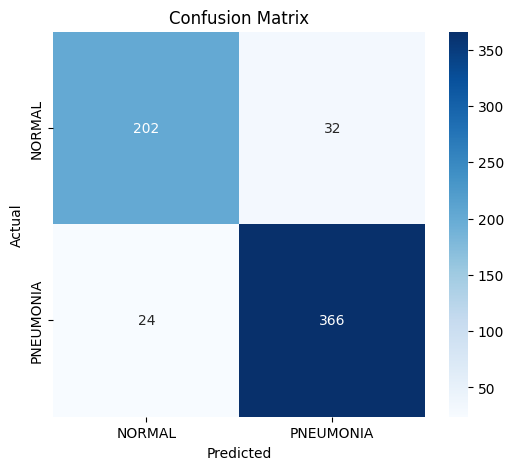

              precision    recall  f1-score   support

      NORMAL       0.89      0.86      0.88       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [16]:
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_labels.values()))

In [24]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score,
    log_loss, matthews_corrcoef, balanced_accuracy_score, classification_report
)

import numpy as np
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def preprocess_image(img_path, target_size=(480, 480)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

pneumonia_images = glob.glob("/content/chest_xray/test/PNEUMONIA/*.jpeg")
normal_images = glob.glob("/content/chest_xray/test/NORMAL/*.jpeg")

test_images = pneumonia_images + normal_images
true_labels = [1] * len(pneumonia_images) + [0] * len(normal_images)

correct_count = 0

print("\n📌 **Test Image Predictions:**\n")

for img_path, true_label in zip(test_images, true_labels):
    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)[0][0]
    predicted_label = 1 if prediction > 0.5 else 0
    label_name = "Pneumonia" if predicted_label == 1 else "Normal"
    true_label_name = "Pneumonia" if true_label == 1 else "Normal"

    if predicted_label == true_label:
        correct_count += 1
        result = "✅ Correct"
    else:
        result = "❌ Incorrect"

    print(f"🔹 Image: {img_path.split('/')[-1]}")
    print(f"   - Predicted: {label_name} ({prediction:.4f})")
    print(f"   - Actual: {true_label_name}")
    print(f"   - Result: {result}\n")

total_images = len(test_images)
accuracy = correct_count / total_images * 100
print(f"\n🎯 **Final Classification Accuracy:** {correct_count}/{total_images} images correctly classified ({accuracy:.2f}%)")



📌 **Test Image Predictions:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
🔹 Image: person147_bacteria_711.jpeg
   - Predicted: Pneumonia (0.9934)
   - Actual: Pneumonia
   - Result: ✅ Correct

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
🔹 Image: person119_bacteria_566.jpeg
   - Predicted: Pneumonia (0.9997)
   - Actual: Pneumonia
   - Result: ✅ Correct

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
🔹 Image: person1622_virus_2810.jpeg
   - Predicted: Pneumonia (0.9998)
   - Actual: Pneumonia
   - Result: ✅ Correct

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
🔹 Image: person1641_virus_2840.jpeg
   - Predicted: Pneumonia (0.9997)
   - Actual: Pneumonia
   - Result: ✅ Correct

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
🔹 Image: person1660_virus_2869.jpeg
   - Predicted: Pneumonia (0.9575)
   - Actual: Pneumonia
   - Result: ✅ Correct

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
🔹 Image: person134_bacteria_640.jpeg
   - Predicted: Pneumonia (0.9905)
   - Actual: Pneumonia
   - Result: ✅ Correct

1/1 ━━━━━━━━━━━━━━━━━━━

## Testing on images

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, target_size=(480, 480)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


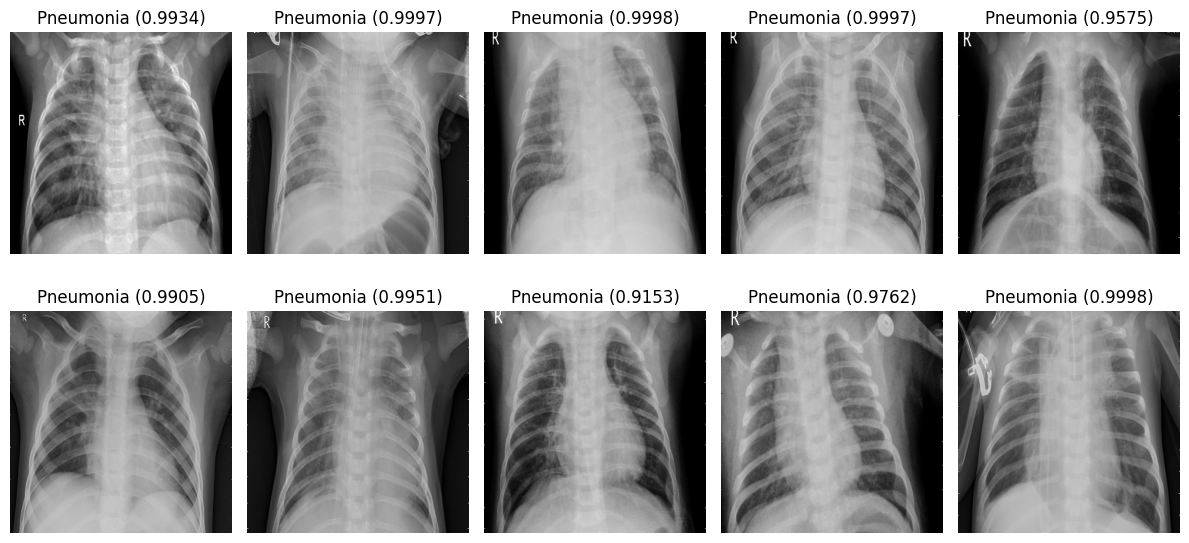

In [20]:
import glob

test_images = glob.glob("/content/chest_xray/test/PNEUMONIA/*.jpeg")[:10]

num_images = len(test_images)
cols = 5
rows = (num_images // cols) + (num_images % cols > 0)

plt.figure(figsize=(12, 6))

for i, img_path in enumerate(test_images):
    img_array, original_img = preprocess_image(img_path)
    prediction = model.predict(img_array)[0][0]
    label = "Pneumonia" if prediction > 0.5 else "Normal"

    plt.subplot(rows, cols, i + 1)
    plt.imshow(original_img)
    plt.title(f"{label} ({prediction:.4f})")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


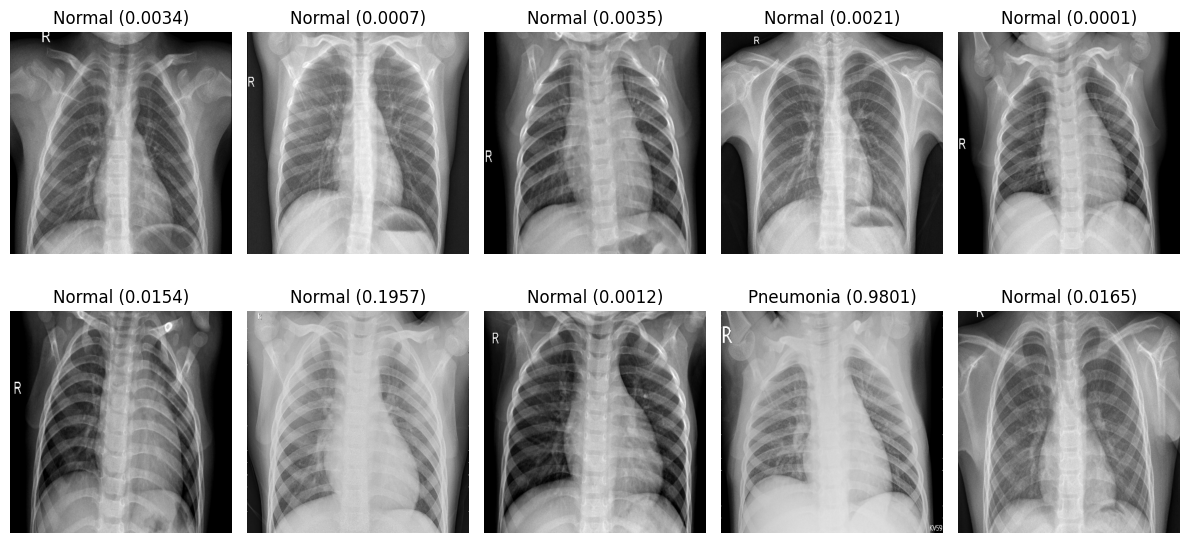

In [21]:
import glob

test_images = glob.glob("/content/chest_xray/test/NORMAL/*.jpeg")[:10]

num_images = len(test_images)
cols = 5
rows = (num_images // cols) + (num_images % cols > 0)

plt.figure(figsize=(12, 6))

for i, img_path in enumerate(test_images):
    img_array, original_img = preprocess_image(img_path)
    prediction = model.predict(img_array)[0][0]
    label = "Pneumonia" if prediction > 0.5 else "Normal"

    plt.subplot(rows, cols, i + 1)
    plt.imshow(original_img)
    plt.title(f"{label} ({prediction:.4f})")
    plt.axis("off")

plt.tight_layout()
plt.show()